In [1]:
#inputs are: gradient at point and previous y value
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_inputs = 2
n_neurons = 100
n_steps = 200
n_outputs = 1

In [3]:
X = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_outputs])

In [4]:
def get_next_batch(batch_size, n_steps):
    X = []
    gradients_X = []
    #get random consecutive points and calculate sin of them
    starting = np.random.rand(batch_size, 1)
    for i in range(n_steps):
        X.append(np.sin(starting + (i/10)))
        #gradient
        temp_grads = []
        grad = np.cos(starting + (i / 10))
        for g in grad:
            if g > 0:
                temp_grads.append([1])
            else:
                temp_grads.append([0])
        gradients_X.append(temp_grads)
#     gradients_y = gradients_X.copy()
#     gradients_y.pop(0)
#     temp_grads_y = []
#     grad_y = np.cos(starting + (n_steps / 10))
#     for g in grad_y:
#         if g > 0:
#             temp_grads_y.append([1])
#         else:
#             temp_grads_y.append([0])
#     gradients_y.append(temp_grads_y)
    
#     y = X.copy()
#     y.pop(0)
#     y.append(np.sin(starting + n_steps / 10))
#     y_np = np.asarray(y).reshape(-1, n_steps, 1)
#     gradients_y_np = np.asarray(gradients_y).reshape(-1, n_steps, 1)
#     y_np_full = np.append(y_np, gradients_y_np, axis=2)
    y = X.copy()
    y.pop(0)
    y.append(np.sin(starting + n_steps / 10))
    y_np = np.asarray(y).reshape(-1, n_steps, 1)
    
    X_np = np.asarray(X).reshape(-1, n_steps, 1)
    gradients_X_np = np.asarray(gradients_X).reshape(-1, n_steps, 1)
    X_np_full = np.append(X_np, gradients_X_np, axis=2)
    return X_np_full, y_np

In [5]:
def get_test_batch(n_steps):
    X = []
    X_grads = []
    #get random consecutive points and their gradients
    starting = np.random.rand(1)
    for i in range(n_steps):
        X.append(starting + (i/10))
        temp_grads = []
        grad = np.cos(starting + (i/10))
        for g in grad:
            if g > 0:
                temp_grads.append([1])
            else:
                temp_grads.append([0])
        X_grads.append(temp_grads)
    X_sin = np.sin(X)
    X_np = np.asarray(X_sin).reshape(-1, n_steps, 1)
    X_grads_np = np.asarray(X_grads).reshape(-1, n_steps, 1)
    X_np_full = np.append(X_np, X_grads_np, axis=2)
    return X_np_full

In [6]:
xd = get_test_batch(10)
print(xd)

[[[0.63887386 1.        ]
  [0.71248514 1.        ]
  [0.77897752 1.        ]
  [0.8376866  1.        ]
  [0.8880258  1.        ]
  [0.92949214 1.        ]
  [0.9616713  1.        ]
  [0.98424176 1.        ]
  [0.996978   1.        ]
  [0.99975276 0.        ]]]


In [7]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [8]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs - y))

In [9]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [10]:
init = tf.global_variables_initializer()

In [11]:
saver = tf.train.Saver()

In [12]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for i in range(n_iterations):
        X_batch, y_batch = get_next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(mse)
    saver.save(sess, "./sin-two-input-model")

0.32155305
0.008956168
0.0009285245
0.00045122937
0.00034306175
0.00033912528
0.00032291783
0.00026704825
0.00030154892
0.00028874184
0.0002744112
0.00022369297
0.0002219376
0.00020275393
0.00020607881


INFO:tensorflow:Restoring parameters from ./sin-two-input-model


/Users/NIKT/Desktop/Programming/Python/NN/EE/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arcsin
  # This is added back by InteractiveShellApp.init_path()


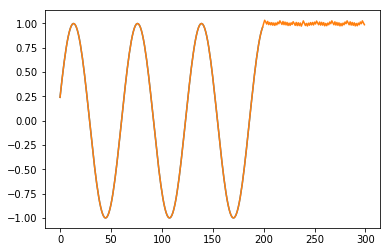

In [17]:
with tf.Session() as sess:
    saver.restore(sess, "./sin-two-input-model")
    #predictions = []
    values = get_test_batch(n_steps)
    predictions = values.reshape(-1, 2).copy().tolist() #convert to python list to have access to append
    for i in range(100):
        X_batch = np.array(predictions[:][-n_steps:]).reshape(1, n_steps, 2)
        #y_pred only holds the y values not gradients
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        y_pred_value = y_pred[0, -1, 0] #get the last element from the predicition (it is the new predicition)
        grad = np.cos(np.arcsin(y_pred_value)) #get the gradient at that new point
        if grad > 0:
            gradient = 1
        else:
            gradient = 0
        pred_combined = [y_pred_value, gradient]
        predictions.append(pred_combined)
    values_points = values[:, :, 0] #values contains both gradient and y value of each point, plot only y value
    predictions_points = np.array(predictions)[:, 0] #again get rid of gradients
    plt.plot(np.arange(values_points.shape[1]).reshape(-1), values_points.reshape(-1)) 
    plt.plot(np.arange(len(predictions_points)), predictions_points)